# T-SNE for Clustering 

T-Sine is a data dimensionality reduction library. It is non-linear, unlike PCA. It aims to retain the proximity of the data points. The nearest neighbours of a point in the origional space considered. The affiliation of this point with a neighbour is modeled by a probability sampled from a gaussian. The probability that these points are affiliated in the lower dimensional space is modeled by sampling from a t-student distribution. These probabilites are placed in the Kullback-Leibler divergance of probabilites. This is then minamised via gradient descent. This is not a convex function and different seeds will cause a diveregence into different local minima. 

This notebooks aims to try and use this algorithm to correctly classify the clusters that have been provided. The hypothesis is that two points in a cluster in the origional space should be strongly affiliated. When the dimensionality is lowered, in general the most strongly affiliated points remain together. Thus if two points remain together this is evidence they are in the same cluster. There is more evidence that could be utilized. Different seeds and perplexities lead to different results. Thus if two points are kept close for many different results, this is further evidence the points belong in the same cluster.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

In [3]:
#fname,fnamey="x_def_3d.dat","y_def_3d.dat"
fname,fnamey="x_3d.dat","y_3d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  D=",D)
x=data

N= 1000   D= 3


In [4]:
def dist(x,i,j):
    return np.linalg.norm(x[i]-x[j])

print(dist(x,13,1))
mdist = np.zeros(N)
for i in range(N):
    dm = 1e100
    for j in range(N):
        if i!=j:
            dij = dist(x,i,j);
            if dij<dm:
                dm = dij
    mdist[i] = dm
mean_min_dist = mdist.mean()
print("mean minimum distance between points: ",mean_min_dist)

1552.6302096770091
mean minimum distance between points:  18.55757910124019


In [5]:
# Create an array of colors that matches the lables.
col = []
red = (1,0,0)
blue = (0,0,1)
yellow = (1,1,0)
for i in range(1000):
    if y[i] == 1:
        col.append(red)
    elif y[i] == 2:
        col.append(yellow)
    else: col.append(blue)

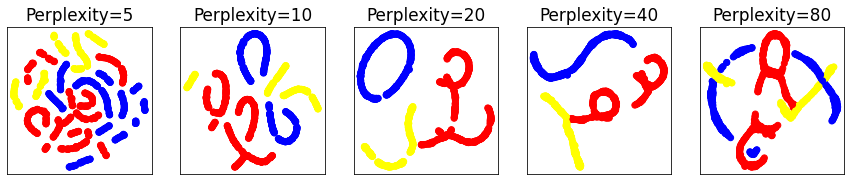

In [12]:
#np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [5, 10, 20, 40, 80]
Np = len(perplexities)

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=None, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=col)#,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## Affiliation Calculation

If two points are strongly affiliated then they are more likly to be in the same cluster. If two points are closer together after T-SNE is applied then they are said to be more strongly affiliated. If they are closer together for many stochasitc itterations of t-SNE then they are also more strongly affiliated. The affiliation of point $p$ between all other points $P$ is calculated as shown below.

$$Affiliation = 1 - norm\left(\sum_{i}dist(p,P)\right)$$

The distance between two points, $p1 = (x_1,y_1)$ and $P_n = (x_2,y_2)$, is calculated as,

$$dist(p,P_n) = \sqrt((x_1 - x_2)^2 + (y_1 - y_2)^2).$$

dist(p,P) outputs an array of distances between $p$ and every other point $P_n$. These distances are summed for every iteration of t-SNE, $i$. At this point $p$ can be said to be most affiliated with the points where this sum is the lowest. Then they will have been closer together for many iterations of t-SNE. This sum is largly dependant on the number of itterations. To remove this dependancy the result is normalised as shown.

$$norm(data) = \frac{data - min(data)}{range(data)}$$

Where data is an array of numbers. Each element is the sum of the distances of $p$ with $P_n$ over many iterations of t-SNE. After normalisation each element in the array represents the affiliation of $p$ with $P_n$, where numbers close to 0 indicate a strong affiliation and numbers close to 1 indicate a low affiliation. This is reversed by subtracting from 1. This makes affiliation easier to represent graphically. 

Thus the affiliation of p with another point $P_n$, has been quantised as a number ranging from 0 to 1. Where a value of 1 means they are strongly affiliated and have been placed close together in many iterations of t-SNE and 0 means they are weakly affiliated and have been placed far apart in many iterations of t-SNE. 

In [15]:
#tsne = manifold.TSNE(n_components=n_components, init='random',
#                         random_state=0, perplexity=perplexity)
#Y = tsne.fit_transform(data)
class point:    
    def __init__(self,index = -1):
        self.clmapPos = []
        
        self.index = index
        self.affiliation = np.empty(N)
        self.totalDist = np.zeros(N)
    def sumDist(self,Y):
        #dist = sqrt((x1-x2)^2 + (y1-y2)^2)
        ind = self.index
        diffSq = (Y[ind,:]-Y)**2
        dist = np.sqrt(diffSq[:,0]+diffSq[:,1])
        self.totalDist = self.totalDist + dist
    def calcAffiliations(self):
        #lower to 0
        self.affiliation = (self.totalDist - np.min(self.totalDist))
        #scale
        self.affiliation = self.affiliation/np.max(self.affiliation)
        self.affiliation = 1 - self.affiliation
    def updateClMapPos(self, current, threshold):
        # filter current map for affiliated points
        filCur = current[self.affiliation > threshold]
#         #remove current point
#         filCur = np.delete(filCur, [self.index], axis = 0)
        #calculate new position as mean of affiliated positions
        newPos = np.mean(filCur,axis = 0)
        current[self.index,:] = newPos
        updatedClMapPos = current
        return updatedClMapPos
        




[[0.35694034 0.93408161]]


In [ ]:
tsne = manifold.TSNE(n_components=2, init='random',
                    random_state=None, perplexity=20)
p1 = point(index = 1)

#re-itterating t-SNE and adding distances between p and Pn
for i in range(100):
    Y = tsne.fit_transform(data)
    p1.sumDist(Y)

p1.calcAffiliations()

Text(0, 0.5, 'Affiliation of $p$ with $P_n$')

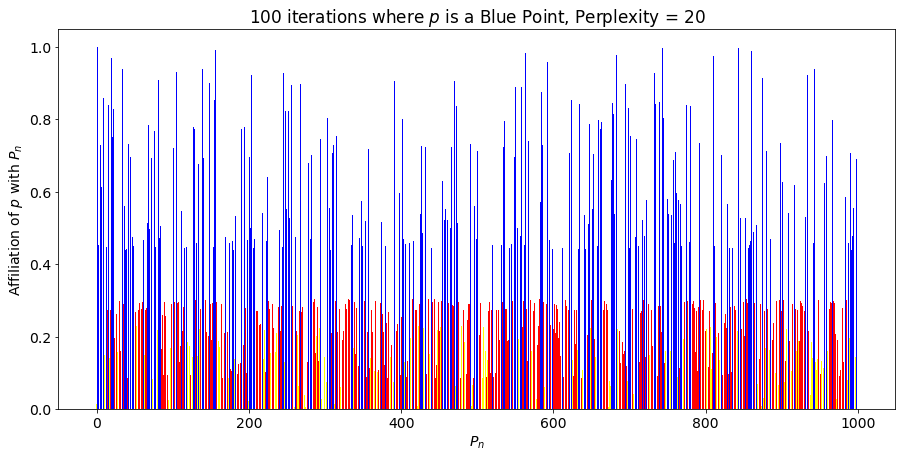

In [28]:
figAffil = plt.figure(figsize = (15,7))
plt.bar(range(1000),p1.affiliation, color = col)
plt.title(r"100 iterations where $p$ is a Blue Point, Perplexity = 20")
plt.xlabel(r"$P_n$")
plt.ylabel(r"Affiliation of $p$ with $P_n$")

Text(0, 0.5, 'Affiliation of $p$ with $P_n$')

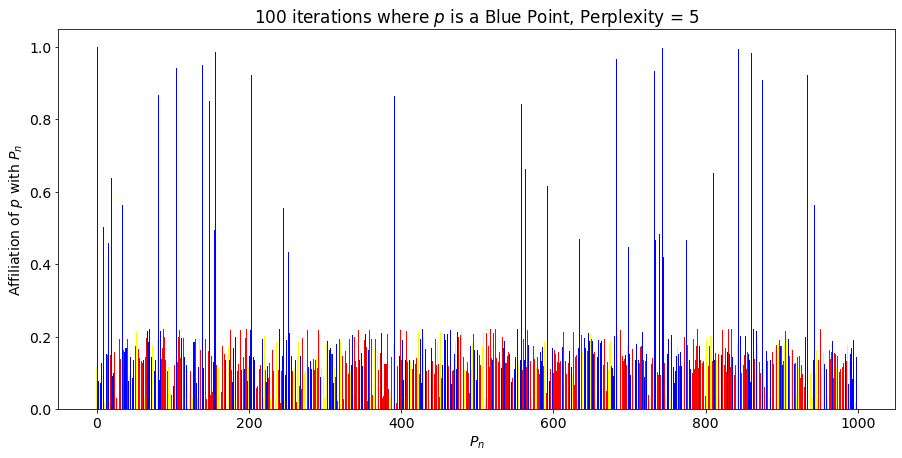

In [33]:
tsne = manifold.TSNE(n_components=2, init='random',
                    random_state=None, perplexity=5)
p1 = point(index = 1)

#re-itterating t-SNE and adding distances between p and Pn
for i in range(100):
    Y = tsne.fit_transform(data)
    p1.sumDist(Y)

p1.calcAffiliations()

figAffil = plt.figure(figsize = (15,7))
plt.bar(range(1000),p1.affiliation, color = col)
plt.title(r"100 iterations where $p$ is a Blue Point, Perplexity = 5")
plt.xlabel(r"$P_n$")
plt.ylabel(r"Affiliation of $p$ with $P_n$")

Text(0, 0.5, 'Affiliation of $p$ with $P_n$')

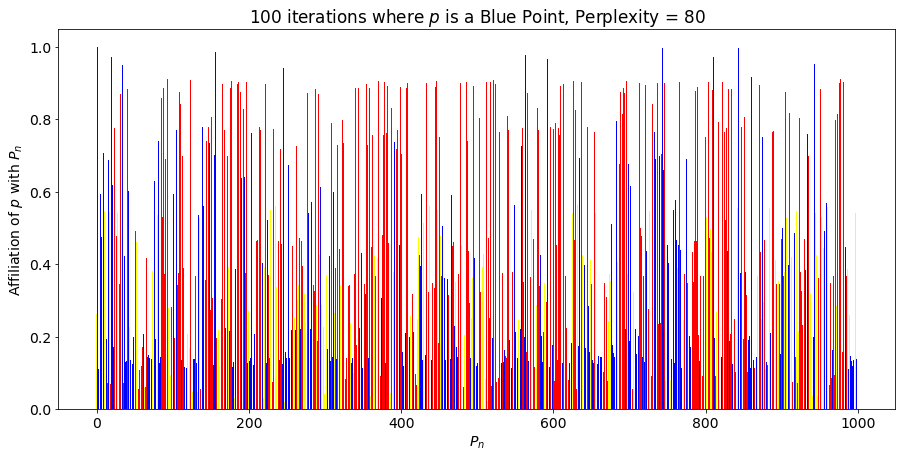

In [7]:
tsne = manifold.TSNE(n_components=2, init='random',
                    random_state=None, perplexity=80)
p1 = point(index = 1)

#re-itterating t-SNE and adding distances between p and Pn
for i in range(100):
    Y = tsne.fit_transform(data)
    p1.sumDist(Y)
s
p1.calcAffiliations()

figAffil = plt.figure(figsize = (15,7))
plt.bar(range(1000),p1.affiliation, color = col)
plt.title(r"100 iterations where $p$ is a Blue Point, Perplexity = 80")
plt.xlabel(r"$P_n$")
plt.ylabel(r"Affiliation of $p$ with $P_n$")

## Preliminary Results

The bar charts above shows the affiliation between a blue point and all other points. It is a blue point because it is appart of the blue cluster in the origional space. The chart has colored the points based on their cluster membership in the origional space.

These plots show that perplexity plays an important role in the results. For perplexity = 20 the results are the best. Most of the other blue points show a stronger affiliation than any other color. For perplexity = 5 the results still show promise. Most points have an affiliation of 0.2. Many blue points have a similar affiliation as the other colors but there are some blue points which show a very strong affiliation compaired tot he others. When the affiliation arrays of the other points are calculated they might have enough cross over to create mapping between clusters. For perplexity = 80, the red points seem to be most affiliated to this blue point. This shows that this method can lead to incorrect conclusions. 
Most of the other blue points show a strong affiliation at different perplexities. This shows that t-SNE has potential to shine light on the affiliation between points or the likelihood of them being in the same cluster.

## Cluster Map

The affiliation information will be used to create a cluster map. A cluster map is something of my own creation. It aims to bring points close together if they are strongly affiliated. 

All points will be randomly placed on a 2D cluster map via the uniform distribution. Then the mapping algorythim will cycle through each point in a random order. For each point it will take all points affiliated above a certain threshold and calculate their mean position on the map. The point will then assume this position.

The hope is by moving points to the 'center' of it's affiliated points I can create blob like clusters that can be easily identified. 

The affiliation information will be found for each point rather than just one as plotted above.

Text(0, 0.5, 'Random y position')

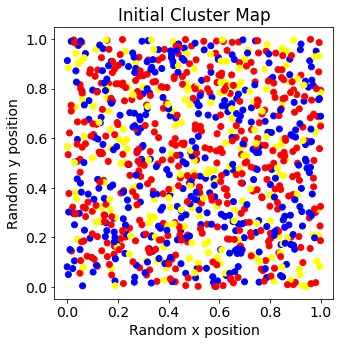

In [20]:
#initial cluster map positions
clMapPos = np.random.random((N,2))

figInitialPos = plt.figure(figsize = (5,5))
plt.scatter(clMapPos[:,0],clMapPos[:,1], color = col)
plt.title("Initial Cluster Map")
plt.xlabel("Random x position")
plt.ylabel("Random y position")

In [91]:
perplexity = [5,20,80]
threshold = [0.3,0.6,0.6]
clMaps = []

for k in range(3):
    tsne = manifold.TSNE(n_components=2, init='random',
                        random_state=None, perplexity=perplexity[k])

    #list of points from the point class
    points = []
    for i in range(N):
        p = point(index = i)
        points.append(p)

    #re-itterating t-SNE and calculating the affiliations bewteen p and Pn
    for i in range(10):
        Y = tsne.fit_transform(data)
        for p in points:
            p.sumDist(Y)
            p.calcAffiliations()

    #Random initial cluster map positions
    clMapPos = np.random.random((N,2))
    #Using last T-SNE output for cluster map 
    #clMapPos = Y
    for p in points:
        p.clmapPos = []
    #number of itterations of cluster map algorythim
    cmaN = 50 
    for i in range(cmaN):
        for p in points:
            clMapPos = p.updateClMapPos(clMapPos,threshold = threshold[k])
    clMaps.append(clMapPos)    



Text(0, 0.5, 'Mean of Affiliated y Positions')

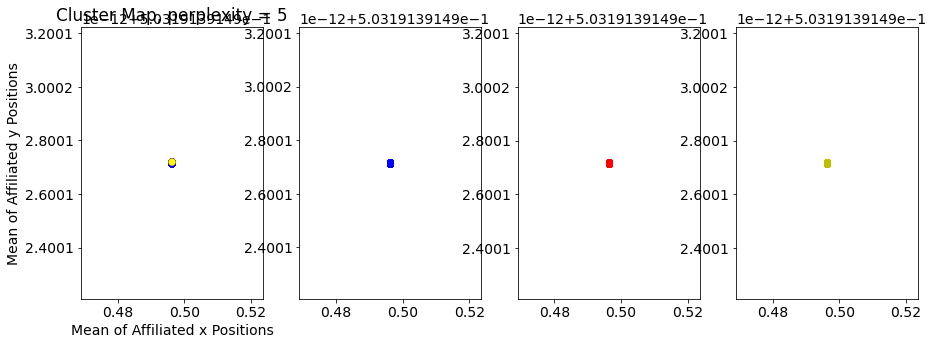

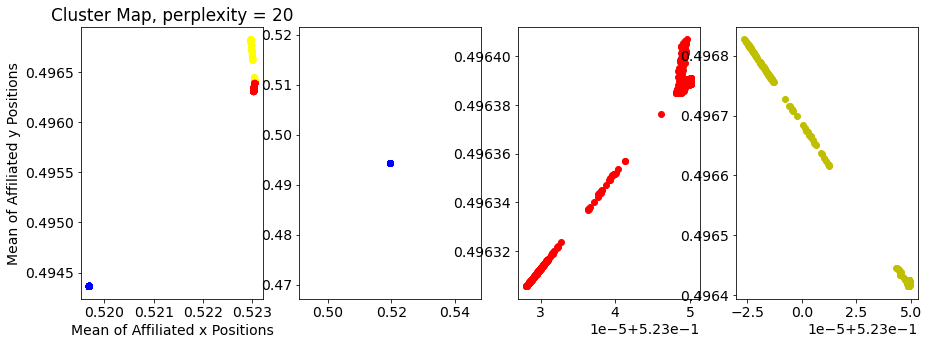

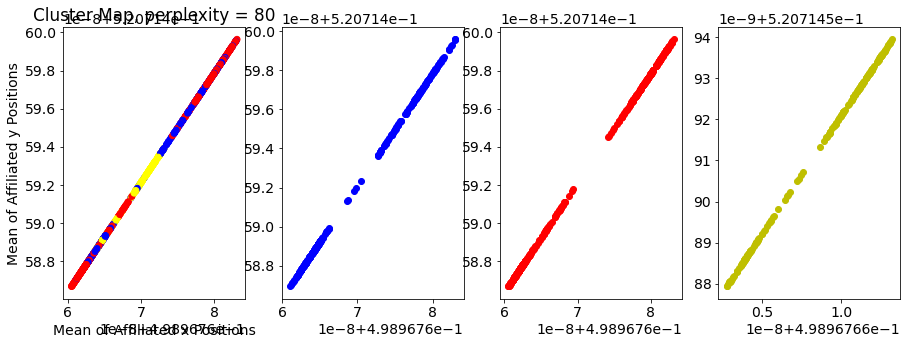

In [92]:
clMap1 = clMaps[0]
clMap2 = clMaps[1]
clMap3 = clMaps[2]

blue = clMap1[y == 0]
red = clMap1[y==1]
yellow = clMap1[y==2]

figNewPos, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize = (15,5))
ax1.scatter(clMap1[:,0],clMap1[:,1], color = col)
ax1.set_title("Cluster Map, perplexity = 5")
ax2.scatter(blue[:,0],blue[:,1], color = 'b')
ax3.scatter(red[:,0],red[:,1], color = 'r')
ax4.scatter(yellow[:,0],yellow[:,1], color = 'y')
ax1.set_xlabel("Mean of Affiliated x Positions")
ax1.set_ylabel("Mean of Affiliated y Positions")

blue = clMap2[y == 0]
red = clMap2[y==1]
yellow = clMap2[y==2]

figNewPos, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize = (15,5))
ax1.scatter(clMap2[:,0],clMap2[:,1], color = col)
ax1.set_title("Cluster Map, perplexity = 20")
ax2.scatter(blue[:,0],blue[:,1], color = 'b')
ax3.scatter(red[:,0],red[:,1], color = 'r')
ax4.scatter(yellow[:,0],yellow[:,1], color = 'y')
ax1.set_xlabel("Mean of Affiliated x Positions")
ax1.set_ylabel("Mean of Affiliated y Positions")

blue = clMap3[y == 0]
red = clMap3[y==1]
yellow = clMap3[y==2]

figNewPos, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize = (15,5))
ax1.scatter(clMap3[:,0],clMap3[:,1], color = col)
ax1.set_title("Cluster Map, perplexity = 80")
ax2.scatter(blue[:,0],blue[:,1], color = 'b')
ax3.scatter(red[:,0],red[:,1], color = 'r')
ax4.scatter(yellow[:,0],yellow[:,1], color = 'y')
ax1.set_xlabel("Mean of Affiliated x Positions")
ax1.set_ylabel("Mean of Affiliated y Positions")

## Cluster Map Results

Please forgive the terrible plotting. I will explaine what is shown in the plots above.
The perplexities 5,20 and 80 are tested. t-SNE is itterated 10 times with no seed. The affiliations are calculated as explained above. The points are randomly placed on the cluster map. Then each point is moved to the mean of the most affiliated points. These points are defined as having an affiliation greater than 0.6. Each point is moved to the mean of the affiliated points 50 times. The result is the left most plot. 

Perplexity = 20 worked the best so it was further analysed. This run veryy nearly successfully identified the clusters. The clusters are so dense on the plot you cannot know if there are red points hidden under the blue ones. To make sure there was no color mixing I plotted the colours seperatly. These plots show there are no far outliers that could be hiding under the points of the other clusters. Except maybe some red and yellow that look a little close. 

# Conclusion 

t-SNE shows potential to be used for clustering. Although my specific algorythim has hyperparameters that I tuned using the known lables, (Perplexity and affiliation threshold). Without the lables it would be very difficult to tune these parameters and identify real clusters. A deeper investigation needs to be carried out to conclude wether or not t-SNE is viable for clustering. 